In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import shutil
# copy olddir to newdir
shutil.copytree('/content/drive/MyDrive/GNN', 'GNN')

'GNN'

In [3]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install dgl

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 5.2 MB/s 
     |████████████████████████████████| 3.5 MB 40.9 MB/s 
     |████████████████████████████████| 2.5 MB 26.9 MB/s 
     |████████████████████████████████| 750 kB 42.8 MB/s 
     |████████████████████████████████| 407 kB 5.2 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=811bbbfa5ca4f21c673e505d20d5630d63f311c931e8ef456e69193346cc6002
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric
     |████████████████████████████████| 4.4 MB 4.6 MB/s 


In [4]:
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch.nn import Linear
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GATConv, global_mean_pool, global_max_pool
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch.nn import Linear
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch

import os
import torch_geometric
from torch_geometric.data import DataLoader
# from torch_geometric.nn import GraphConv
import torch
from torch.nn import Parameter
from torch_geometric.nn.conv import MessagePassing

from torch_geometric.nn.inits import uniform

import os

root = 'GNN/data_used'
label_list = os.listdir(root)
from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import Data


In [5]:

class_dict = {
    "HC": 0,
    "ASD": 1,
}
threshold = 0.2
data_processed = []
for label_files in label_list:
    label = torch.LongTensor([class_dict[label_files]])
    listd = os.listdir(os.path.join(root, label_files))
    for files in listd:
        subj_fc_dir = os.path.join(root, label_files, files)
        subj_mat_fc = np.loadtxt(subj_fc_dir)[:176, :90]
        #print("reading data " + subj_fc_dir)
        subj_mat_fc_adj = np.corrcoef(np.transpose(subj_mat_fc))  #90*90----correlation coefficient
        subj_mat_fc_adj = subj_mat_fc_adj - np.diag(np.diag(subj_mat_fc_adj))
        #take the upper triangle and compute the threshold
        subj_fc_adj_up = subj_mat_fc_adj[np.triu_indices(90, k=1)]
        subj_fc_adj_list = subj_fc_adj_up.reshape((-1))
        thindex = int(threshold * subj_fc_adj_list.shape[0])
        thremax = subj_fc_adj_list[subj_fc_adj_list.argsort()[-1 * thindex - 1]]  #
        #avoiding Nan
        subj_fc_adj_t = np.zeros((90, 90))
        subj_fc_adj_t[subj_mat_fc_adj > thremax] = 1
        subj_mat_fc_adj = subj_fc_adj_t
        fcedge_index, _ = dense_to_sparse(torch.from_numpy(subj_mat_fc_adj.astype(np.int16)))

        subj_mat_fc_list = subj_mat_fc.reshape((-1))
        subj_mat_fc_new = (subj_mat_fc - min(subj_mat_fc_list)) / (
                max(subj_mat_fc_list) - min(subj_mat_fc_list))
        # subj_mat_fc_new = (subj_mat_fc - np.mean(subj_mat_fc, axis=0, keepdims=True)) / np.std(subj_mat_fc, axis=0, keepdims=True)

        subj_mat_fc_new = np.transpose(subj_mat_fc_new)  #90*176

        rowsum = np.array(subj_mat_fc_adj.sum(1))  #row sum #90,
        N = np.diag(rowsum)  #90*90
        degree_C_BOLD = np.concatenate((N, subj_mat_fc_new), 1)  #90*266
        # print(subj_mat_fc_adj)
        # BOLD_C_degree=np.concatenate((subj_mat_fc_new,N),1)
        ###one-hot###
        # subj_mat_fc_new=np.eye(args.num_nodes)
        data_processed.append(
            Data(x=torch.from_numpy(degree_C_BOLD).float(), edge_index=fcedge_index, y=torch.tensor(label)))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [6]:
import random
random.seed(1234)
random.shuffle(data_processed)
data_processed[:5]  #len:618;

[Data(x=[90, 266], edge_index=[2, 1602], y=[1]),
 Data(x=[90, 266], edge_index=[2, 1602], y=[1]),
 Data(x=[90, 266], edge_index=[2, 1602], y=[1]),
 Data(x=[90, 266], edge_index=[2, 1602], y=[1]),
 Data(x=[90, 266], edge_index=[2, 1602], y=[1])]

In [7]:
from sklearn.metrics import confusion_matrix
def confusion(g_turth,predictions):
    # print('g_truth: ', g_turth)
    # print('pred: ', predictions)
    # print('confusion_matrix: ', confusion_matrix(g_turth,predictions).ravel())
    tn, fp, fn, tp = confusion_matrix(g_turth,predictions, labels=[0, 1]).ravel()
    accuracy = (tp+tn)/(tp+fp+tn+fn)
    sensitivity = tp/(tp+fn)
    specificty = tn/(tn+fp)
    return accuracy, sensitivity, specificty

In [8]:
from torch_geometric.nn import GATConv
import copy

In [9]:
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, global_mean_pool, global_max_pool

class GraphSage_Net(torch.nn.Module):
    def __init__(self, features, classes):
        super(GraphSage_Net, self).__init__()
        num_layers = 3
        dim_embedding = 32
        self.aggregation = 'max'

        if self.aggregation == 'max':
            self.fc_max = nn.Linear(dim_embedding, dim_embedding)

        self.layers = nn.ModuleList([])
        for i in range(num_layers):
            dim_input = features if i == 0 else dim_embedding
            conv = SAGEConv(dim_input, dim_embedding)
            conv.aggr = self.aggregation
            self.layers.append(conv)

        self.fc1 = nn.Linear(num_layers * dim_embedding, dim_embedding)
        self.fc2 = nn.Linear(dim_embedding, classes)

    def forward(self, data, x0_b, edge_index_B,lam):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x_all = []
        x_b_all = []
        x_b = copy.deepcopy(x0_b)
        for i, layer in enumerate(self.layers):
            x = layer(x, edge_index)
            x_b = layer(x_b, edge_index_B)
            if self.aggregation == 'max':
                x = torch.tanh(self.fc_max(x))
                x_b = torch.tanh(self.fc_max(x))
            x = F.dropout(x, p=0.5, training=self.training)
            x_b = F.dropout(x_b, p=0.5, training=self.training)
            x_all.append(x)
            x_b_all.append(x_b)       

        x = torch.cat(x_all, dim=1)
        x_b = torch.cat(x_b_all, dim=1)

        x = x * lam + x_b * (1-lam)
        x = global_max_pool(x, batch)
        
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
def train(model, optimizer, criterion, train_loader, mixup):
    model.train()

    if mixup:
        lam = np.random.beta(4.0, 4.0)
    else:
        lam = 1.0
    for data in train_loader:
        optimizer.zero_grad()
        data_b = copy.deepcopy(data)
        random.shuffle(data_b)
        data.to(device)
        data_b.to(device)
        out = model(data.to(device), data_b.x.to(device), data_b.edge_index , lam)
        loss = criterion(out.to(device), data.y.to(device)) * lam + \
           criterion(out.to(device), data_b.y.to(device)) * (1 - lam)

        loss.backward()
        optimizer.step()

def test(model, loader):
    model.eval()

    accuracy,sensitivity,specificty = 0, 0, 0
    for data in loader:                            # batch iteration over the test set dataset
        data_b = copy.deepcopy(data)
        random.shuffle(data_b)
        data.to(device)
        data_b(device)
        out = model(data,data_b.x.to(device), data_b.edge_index.to(device), 1) # one feed forward
        pred = out.argmax(dim=1)                         # use category with highest probability
        accuracy,sensitivity,specificty = confusion(g_turth=data.y.cpu(), predictions=pred.cpu())
    return accuracy,sensitivity,specificty

cuda


In [11]:
def get_loader_info(loader, name):
    print(name)
    for step, data in enumerate(loader):
        print(f'Step {step + 1}:')
        print('=======')
        print(f'Number of graphs in the current batch: {data.num_graphs}')
        print(data)
        print()

In [12]:
def get_k_fold_data(k, i, dataset):
    # return the training and test data required for the i-th fold cross-validation, separated
    assert k > 1
    # print(len(dataset))
    fold_size = len(dataset) // k  # num of pieces per copy: total number of data items/number of folds (rounded down)

    dataset_train = None
    dataset_test = None
    for j in range(k):
        # idx = slice(j * fold_size, (j + 1) * fold_size)  # slice(start,end,step): func for slice, get the idx of the test set
        # print(idx)
        # X_part, y_part = X[idx, :], y[idx]
        dataset_part = dataset[j * fold_size : (j + 1) * fold_size]
        # just slice the first dim
        if j == i:  # i-th fold as test
            dataset_test = dataset_part
        elif dataset_train is None:
            dataset_train = dataset_part
        else:
            dataset_train += dataset_part # concat other folds, only to the first dim
    return dataset_train, dataset_test

In [13]:
import matplotlib.pyplot as plt
def myplot(x_data, y_data, y_data2, y_data3, k, mod, m):
    ln1, = plt.plot(x_data,y_data,color='red',linewidth=2.0,linestyle='-')
    ln2, = plt.plot(x_data,y_data2,color='blue',linewidth=2.0,linestyle='-')
    ln3, = plt.plot(x_data,y_data3,color='green',linewidth=2.0,linestyle='-')


    plt.title(m + ' ' + mod + " fold: " + str(k)) 

    plt.legend(handles=[ln1,ln2,ln3],labels=['Acc','Sensitivity', 'Specificty'])

    ax = plt.gca()
    ax.spines['right'].set_color('none')  
    ax.spines['top'].set_color('none') 
    plt.savefig('GNN/img/'+mod+'{} fold.png'.format(k))
    plt.show()

In [14]:
def k_fold(k, dataset, num_epochs=100, learning_rate=0.001, batch_size=64):
    for i in range(k):
        model = GraphSage_Net(266, 2).to(device)
        model.to(device)
        train_dataset_, test_dataset = get_k_fold_data(k, i, dataset)
        train_dataset, valid_dataset = get_k_fold_data(k, i, train_dataset_)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
        print(model)
        # get_loader_info(train_loader, 'train_loader')
        # get_loader_info(test_loader, 'test_loader')
        # get_loader_info(valid_loader, 'valid_loader')
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = torch.nn.CrossEntropyLoss()
        t_a_l = []
        t_sst_l = []
        t_sp_l = []
        v_a_l = []
        v_sst_l = []
        v_sp_l = []
        for epoch in range(1, num_epochs):
            train(model=model, optimizer=optimizer, criterion=criterion, train_loader=train_loader, mixup=False)
            train(model=model, optimizer=optimizer, criterion=criterion, train_loader=train_loader, mixup=False)
            train_accuracy, train_sensitivity, train_specificity = test(model=model, loader=train_loader)
            t_a_l.append(train_accuracy)
            t_sst_l.append(train_sensitivity)
            t_sp_l.append(train_specificity)
            valid_accuracy, valid_sensitivity, valid_specificity = test(model=model, loader=valid_loader)
            v_a_l.append(valid_accuracy)
            v_sst_l.append(valid_sensitivity)
            v_sp_l.append(valid_specificity)
            # if epoch % 2 == 0:
            print(f'Fold: {i:01d}: Epoch: {epoch:03d}, Train Acc: {train_accuracy:.4f}, Train sensitivity: {train_sensitivity: .4f}, Train specificity: {train_specificity: .4f} \n\t\t\t\t\t Valid Acc: {valid_accuracy:.4f}, Valid sensitivity: {valid_sensitivity: .4f}, Valid specificity: {valid_specificity: .4f}')
        x = list(np.array(list(range(1,num_epochs))))
        print(x)
        myplot(x_data=x, y_data=t_a_l, y_data2=t_sst_l, y_data3=t_sp_l, k=i, mod='train', m='GraphSAGE+mixup')
        myplot(x_data=x, y_data=v_a_l, y_data2=v_sst_l, y_data3=v_sp_l, k=i, mod='valid', m='GraphSAGE+mixup')
        test_accuracy, test_sensitivity, test_specificity = test(model=model, loader=test_loader)
        print(f'Fold: {i:01d}:  Test Acc: {test_accuracy:.4f}, Test sensitivity: {test_sensitivity: .4f}, Test specificity: {test_specificity: .4f}')

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


GraphSage_Net(
  (fc_max): Linear(in_features=32, out_features=32, bias=True)
  (layers): ModuleList(
    (0): SAGEConv(266, 32)
    (1): SAGEConv(32, 32)
    (2): SAGEConv(32, 32)
  )
  (fc1): Linear(in_features=96, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)
Fold: 0: Epoch: 001, Train Acc: 0.5000, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4815, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 0: Epoch: 002, Train Acc: 0.6579, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4815, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 0: Epoch: 003, Train Acc: 0.5263, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4815, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 0: Epoch: 004, Train Acc: 0.4737, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4815, Valid sensitivity:  0.0000, Valid specificity

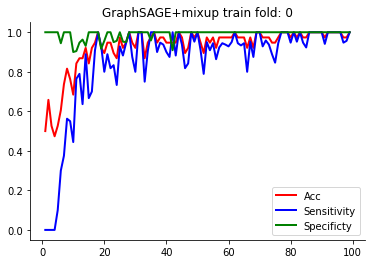

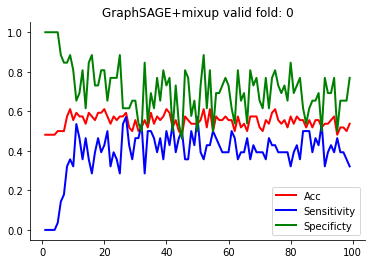

Fold: 0:  Test Acc: 0.6393, Test sensitivity:  0.3333, Test specificity:  0.8824
GraphSage_Net(
  (fc_max): Linear(in_features=32, out_features=32, bias=True)
  (layers): ModuleList(
    (0): SAGEConv(266, 32)
    (1): SAGEConv(32, 32)
    (2): SAGEConv(32, 32)
  )
  (fc1): Linear(in_features=96, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold: 1: Epoch: 001, Train Acc: 0.5000, Train sensitivity:  0.9444, Train specificity:  0.1000 
					 Valid Acc: 0.5370, Valid sensitivity:  0.8966, Valid specificity:  0.1200
Fold: 1: Epoch: 002, Train Acc: 0.6842, Train sensitivity:  0.2941, Train specificity:  1.0000 
					 Valid Acc: 0.4630, Valid sensitivity:  0.1379, Valid specificity:  0.8400
Fold: 1: Epoch: 003, Train Acc: 0.7105, Train sensitivity:  0.3529, Train specificity:  1.0000 
					 Valid Acc: 0.5741, Valid sensitivity:  0.3103, Valid specificity:  0.8800
Fold: 1: Epoch: 004, Train Acc: 0.5526, Train sensitivity:  1.0000, Train specificity:  0.2917 
					 Valid Acc: 0.5370, Valid sensitivity:  0.9310, Valid specificity:  0.0800
Fold: 1: Epoch: 005, Train Acc: 0.6316, Train sensitivity:  0.1765, Train specificity:  1.0000 
					 Valid Acc: 0.5926, Valid sensitivity:  0.3103, Valid specificity:  0.9200
Fold: 1: Epoch: 006, Train Acc: 0.7632, Train sensitivity:  0.6154, Train specificity:  0.8400 
					 Valid Acc: 0.6296,

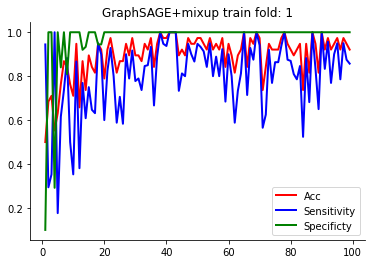

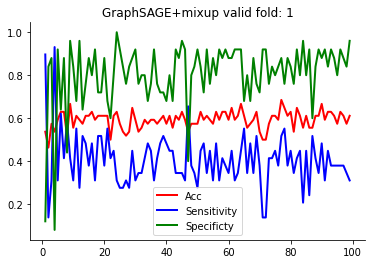

Fold: 1:  Test Acc: 0.5902, Test sensitivity:  0.3333, Test specificity:  0.8387
GraphSage_Net(
  (fc_max): Linear(in_features=32, out_features=32, bias=True)
  (layers): ModuleList(
    (0): SAGEConv(266, 32)
    (1): SAGEConv(32, 32)
    (2): SAGEConv(32, 32)
  )
  (fc1): Linear(in_features=96, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold: 2: Epoch: 001, Train Acc: 0.6316, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.6296, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 2: Epoch: 002, Train Acc: 0.5000, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.6296, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 2: Epoch: 003, Train Acc: 0.5263, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.6296, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 2: Epoch: 004, Train Acc: 0.6842, Train sensitivity:  0.3125, Train specificity:  0.9545 
					 Valid Acc: 0.5741, Valid sensitivity:  0.1000, Valid specificity:  0.8529
Fold: 2: Epoch: 005, Train Acc: 0.5789, Train sensitivity:  0.9500, Train specificity:  0.1667 
					 Valid Acc: 0.4074, Valid sensitivity:  0.9500, Valid specificity:  0.0882
Fold: 2: Epoch: 006, Train Acc: 0.5263, Train sensitivity:  1.0000, Train specificity:  0.0526 
					 Valid Acc: 0.3889,

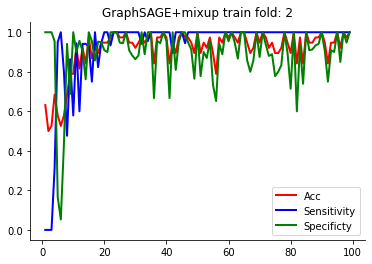

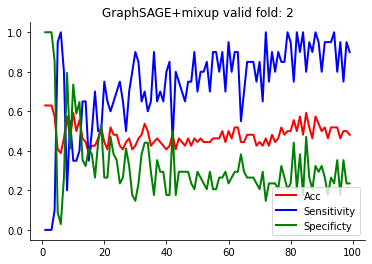

Fold: 2:  Test Acc: 0.4918, Test sensitivity:  0.6923, Test specificity:  0.3429
GraphSage_Net(
  (fc_max): Linear(in_features=32, out_features=32, bias=True)
  (layers): ModuleList(
    (0): SAGEConv(266, 32)
    (1): SAGEConv(32, 32)
    (2): SAGEConv(32, 32)
  )
  (fc1): Linear(in_features=96, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold: 3: Epoch: 001, Train Acc: 0.5263, Train sensitivity:  0.8235, Train specificity:  0.2857 
					 Valid Acc: 0.4074, Valid sensitivity:  0.7083, Valid specificity:  0.1667
Fold: 3: Epoch: 002, Train Acc: 0.5526, Train sensitivity:  0.0588, Train specificity:  0.9524 
					 Valid Acc: 0.5556, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 3: Epoch: 003, Train Acc: 0.4211, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5556, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 3: Epoch: 004, Train Acc: 0.5526, Train sensitivity:  0.3000, Train specificity:  0.8333 
					 Valid Acc: 0.5370, Valid sensitivity:  0.2917, Valid specificity:  0.7333
Fold: 3: Epoch: 005, Train Acc: 0.4737, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.5370, Valid sensitivity:  0.0000, Valid specificity:  0.9667
Fold: 3: Epoch: 006, Train Acc: 0.7105, Train sensitivity:  0.4444, Train specificity:  0.9500 
					 Valid Acc: 0.6481,

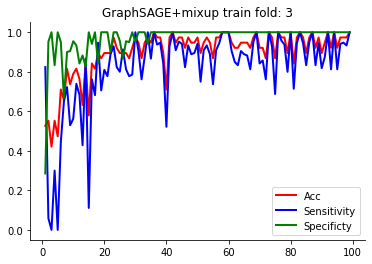

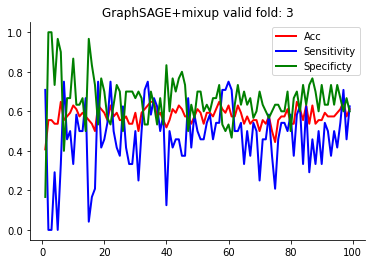

Fold: 3:  Test Acc: 0.5410, Test sensitivity:  0.5200, Test specificity:  0.5556
GraphSage_Net(
  (fc_max): Linear(in_features=32, out_features=32, bias=True)
  (layers): ModuleList(
    (0): SAGEConv(266, 32)
    (1): SAGEConv(32, 32)
    (2): SAGEConv(32, 32)
  )
  (fc1): Linear(in_features=96, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold: 4: Epoch: 001, Train Acc: 0.5263, Train sensitivity:  1.0000, Train specificity:  0.0526 
					 Valid Acc: 0.4815, Valid sensitivity:  0.8929, Valid specificity:  0.0385
Fold: 4: Epoch: 002, Train Acc: 0.5789, Train sensitivity:  0.5000, Train specificity:  0.6250 
					 Valid Acc: 0.5556, Valid sensitivity:  0.5000, Valid specificity:  0.6154
Fold: 4: Epoch: 003, Train Acc: 0.6053, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4815, Valid sensitivity:  0.0714, Valid specificity:  0.9231
Fold: 4: Epoch: 004, Train Acc: 0.6053, Train sensitivity:  0.8824, Train specificity:  0.3810 
					 Valid Acc: 0.5556, Valid sensitivity:  0.8929, Valid specificity:  0.1923
Fold: 4: Epoch: 005, Train Acc: 0.6316, Train sensitivity:  0.8889, Train specificity:  0.4000 
					 Valid Acc: 0.5741, Valid sensitivity:  0.9286, Valid specificity:  0.1923
Fold: 4: Epoch: 006, Train Acc: 0.7895, Train sensitivity:  0.7222, Train specificity:  0.8500 
					 Valid Acc: 0.5556,

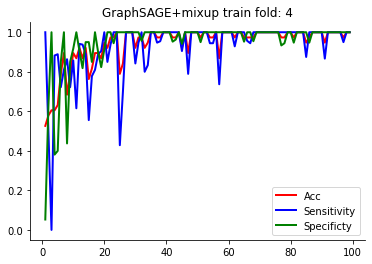

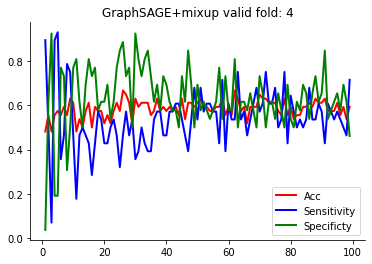

Fold: 4:  Test Acc: 0.5902, Test sensitivity:  0.6757, Test specificity:  0.4583
GraphSage_Net(
  (fc_max): Linear(in_features=32, out_features=32, bias=True)
  (layers): ModuleList(
    (0): SAGEConv(266, 32)
    (1): SAGEConv(32, 32)
    (2): SAGEConv(32, 32)
  )
  (fc1): Linear(in_features=96, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold: 5: Epoch: 001, Train Acc: 0.5526, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4259, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 5: Epoch: 002, Train Acc: 0.4474, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4259, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 5: Epoch: 003, Train Acc: 0.6316, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4259, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 5: Epoch: 004, Train Acc: 0.5526, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4259, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 5: Epoch: 005, Train Acc: 0.5263, Train sensitivity:  0.1500, Train specificity:  0.9444 
					 Valid Acc: 0.4444, Valid sensitivity:  0.0323, Valid specificity:  1.0000
Fold: 5: Epoch: 006, Train Acc: 0.7368, Train sensitivity:  0.5333, Train specificity:  0.8696 
					 Valid Acc: 0.6296,

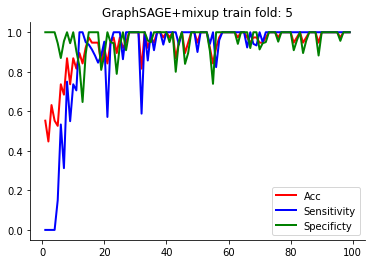

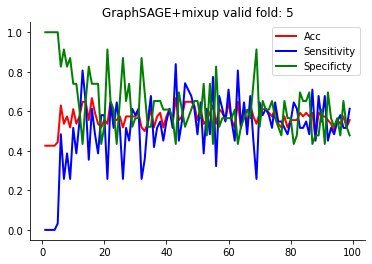

Fold: 5:  Test Acc: 0.5902, Test sensitivity:  0.5588, Test specificity:  0.6296
GraphSage_Net(
  (fc_max): Linear(in_features=32, out_features=32, bias=True)
  (layers): ModuleList(
    (0): SAGEConv(266, 32)
    (1): SAGEConv(32, 32)
    (2): SAGEConv(32, 32)
  )
  (fc1): Linear(in_features=96, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold: 6: Epoch: 001, Train Acc: 0.7368, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4815, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 6: Epoch: 002, Train Acc: 0.5789, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4815, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 6: Epoch: 003, Train Acc: 0.4737, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4815, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 6: Epoch: 004, Train Acc: 0.6579, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4815, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 6: Epoch: 005, Train Acc: 0.5526, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4815, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 6: Epoch: 006, Train Acc: 0.4474, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.4815,

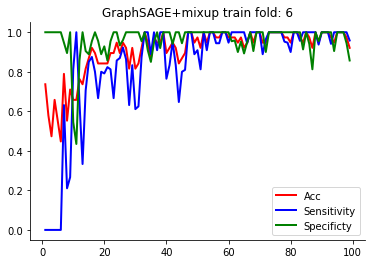

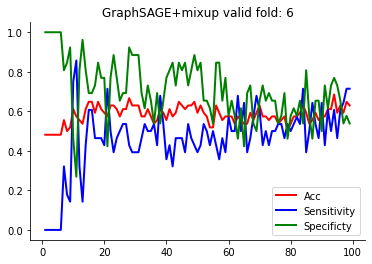

Fold: 6:  Test Acc: 0.5902, Test sensitivity:  0.6400, Test specificity:  0.5556
GraphSage_Net(
  (fc_max): Linear(in_features=32, out_features=32, bias=True)
  (layers): ModuleList(
    (0): SAGEConv(266, 32)
    (1): SAGEConv(32, 32)
    (2): SAGEConv(32, 32)
  )
  (fc1): Linear(in_features=96, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold: 7: Epoch: 001, Train Acc: 0.5526, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.6111, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 7: Epoch: 002, Train Acc: 0.5526, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.6111, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 7: Epoch: 003, Train Acc: 0.5000, Train sensitivity:  0.0000, Train specificity:  1.0000 
					 Valid Acc: 0.6111, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 7: Epoch: 004, Train Acc: 0.5526, Train sensitivity:  0.0000, Train specificity:  0.9545 
					 Valid Acc: 0.6111, Valid sensitivity:  0.0000, Valid specificity:  1.0000
Fold: 7: Epoch: 005, Train Acc: 0.5789, Train sensitivity:  0.1176, Train specificity:  0.9524 
					 Valid Acc: 0.6111, Valid sensitivity:  0.0476, Valid specificity:  0.9697
Fold: 7: Epoch: 006, Train Acc: 0.7632, Train sensitivity:  0.7778, Train specificity:  0.7500 
					 Valid Acc: 0.7037,

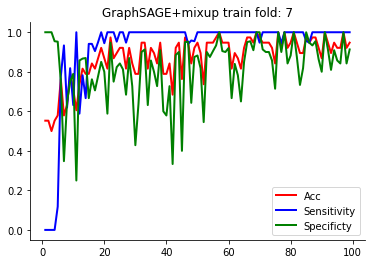

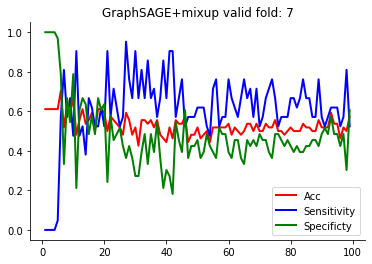

Fold: 7:  Test Acc: 0.5246, Test sensitivity:  0.5000, Test specificity:  0.5455
GraphSage_Net(
  (fc_max): Linear(in_features=32, out_features=32, bias=True)
  (layers): ModuleList(
    (0): SAGEConv(266, 32)
    (1): SAGEConv(32, 32)
    (2): SAGEConv(32, 32)
  )
  (fc1): Linear(in_features=96, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold: 8: Epoch: 001, Train Acc: 0.4474, Train sensitivity:  0.1250, Train specificity:  1.0000 
					 Valid Acc: 0.5741, Valid sensitivity:  0.1200, Valid specificity:  0.9655
Fold: 8: Epoch: 002, Train Acc: 0.6579, Train sensitivity:  0.3077, Train specificity:  0.8400 
					 Valid Acc: 0.5000, Valid sensitivity:  0.2400, Valid specificity:  0.7241
Fold: 8: Epoch: 003, Train Acc: 0.6842, Train sensitivity:  0.3529, Train specificity:  0.9524 
					 Valid Acc: 0.5926, Valid sensitivity:  0.1600, Valid specificity:  0.9655
Fold: 8: Epoch: 004, Train Acc: 0.6579, Train sensitivity:  0.5294, Train specificity:  0.7619 
					 Valid Acc: 0.6111, Valid sensitivity:  0.6000, Valid specificity:  0.6207
Fold: 8: Epoch: 005, Train Acc: 0.7105, Train sensitivity:  0.6667, Train specificity:  0.7308 
					 Valid Acc: 0.6481, Valid sensitivity:  0.5200, Valid specificity:  0.7586
Fold: 8: Epoch: 006, Train Acc: 0.5000, Train sensitivity:  0.2273, Train specificity:  0.8750 
					 Valid Acc: 0.5926,

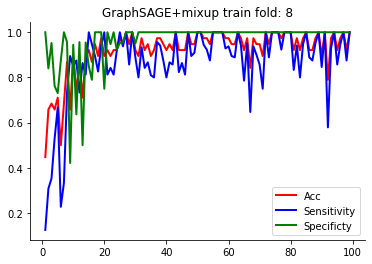

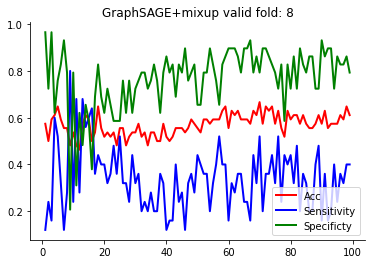

Fold: 8:  Test Acc: 0.5410, Test sensitivity:  0.4516, Test specificity:  0.6333
GraphSage_Net(
  (fc_max): Linear(in_features=32, out_features=32, bias=True)
  (layers): ModuleList(
    (0): SAGEConv(266, 32)
    (1): SAGEConv(32, 32)
    (2): SAGEConv(32, 32)
  )
  (fc1): Linear(in_features=96, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold: 9: Epoch: 001, Train Acc: 0.4211, Train sensitivity:  1.0000, Train specificity:  0.1200 
					 Valid Acc: 0.4630, Valid sensitivity:  0.9259, Valid specificity:  0.0000
Fold: 9: Epoch: 002, Train Acc: 0.4474, Train sensitivity:  1.0000, Train specificity:  0.0000 
					 Valid Acc: 0.5000, Valid sensitivity:  1.0000, Valid specificity:  0.0000
Fold: 9: Epoch: 003, Train Acc: 0.6053, Train sensitivity:  1.0000, Train specificity:  0.2857 
					 Valid Acc: 0.5000, Valid sensitivity:  0.7778, Valid specificity:  0.2222
Fold: 9: Epoch: 004, Train Acc: 0.5000, Train sensitivity:  0.9412, Train specificity:  0.1429 
					 Valid Acc: 0.5370, Valid sensitivity:  0.8889, Valid specificity:  0.1852
Fold: 9: Epoch: 005, Train Acc: 0.5789, Train sensitivity:  1.0000, Train specificity:  0.2000 
					 Valid Acc: 0.5000, Valid sensitivity:  0.8148, Valid specificity:  0.1852
Fold: 9: Epoch: 006, Train Acc: 0.6579, Train sensitivity:  0.3333, Train specificity:  0.9500 
					 Valid Acc: 0.5741,

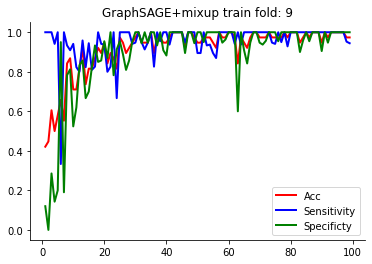

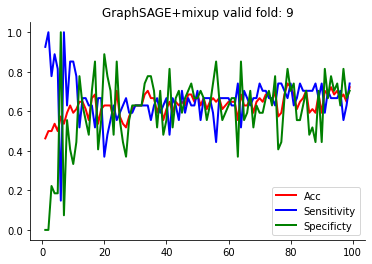

Fold: 9:  Test Acc: 0.5738, Test sensitivity:  0.4800, Test specificity:  0.6389


In [15]:
k_fold(10, dataset=data_processed, num_epochs=100)